In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alfanme","key":"fa3fac860fa3de1e829f7441c419e299"}'}

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d alfanme/indonesian-batik-motifs-corak-app

 98% 111M/114M [00:00<00:00, 167MB/s] 
100% 114M/114M [00:00<00:00, 179MB/s]


In [ ]:
!unzip -qq /content/indonesian-batik-motifs-corak-app.zip

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import load_model
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
train_path = '/content/DATASETmin/DATASETmin/TRAIN'
test_path = '/content/DATASETmin/DATASETmin/TEST'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    rotation_range=90,
    fill_mode='reflect',
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=20,
    color_mode='rgb'
)

validation_generator = validation_datagen.flow_from_directory(
    directory=test_path,
    target_size=(224,224),
    class_mode='categorical',
    batch_size=20,
    color_mode='rgb'
)

motives_dict = train_generator.class_indices
print(motives_dict)

Found 700 images belonging to 10 classes.
Found 200 images belonging to 10 classes.
{'Batik Cendrawasih': 0, 'Batik Dayak': 1, 'Batik Ikat Celup': 2, 'Batik Insang': 3, 'Batik Kawung': 4, 'Batik Megamendung': 5, 'Batik Parang': 6, 'Batik Poleng': 7, 'Batik Sekar Jagad': 8, 'Batik Tambal': 9}


In [ ]:
base_model = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    alpha=0.5,
    pooling='avg'
)

base_model.trainable = False

3203072/3201480 [==============================] - 0s 0us/step


In [ ]:
EPOCHS = 50
LEARNING_RATE = 1e-4
TRAIN_STEP = 700//20
VAL_STEP = 200//20

clear_session()

model = Sequential([
    base_model,
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(10, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model.summary()

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=TRAIN_STEP,
    validation_steps=VAL_STEP,
    shuffle=True,
    epochs=EPOCHS,
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_0.50_224 (Functi (None, 1280)              706224    
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 871,482
Trainable params: 165,258
Non-trainable params: 706,224
_________________________________________________________________
Epoch 1/50
35/35 [==============================] - 24s 593ms/step - loss: 2.5836 - accuracy: 0.1400 - val_loss: 2.1611 - val_accuracy: 0.1800
Epoch 2/50
35/35 [==============================] - 20s 571ms/step - loss: 2.0146 - accuracy: 0.277

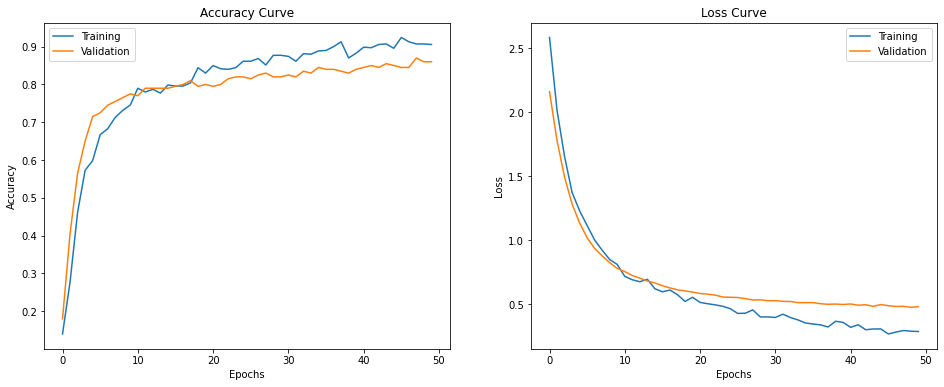

In [9]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.title('Accuracy Curve')
plt.plot(train_acc, label='Training')
plt.plot(val_acc, label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.title('Loss Curve')
plt.plot(train_loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [12]:
test_dir = '/content/DATASETmin/DATASETmin/TEST/'

for motive in motives_dict.keys():
    images_list = os.listdir(os.path.join(test_dir, motive))    
    # plt.figure(figsize=(16, 20))

    correct_count = 0

    for idx, image in enumerate(images_list):
        img_path = f'/content/DATASETv4/DATASET/TEST/{motive}/{image}'
        img = load_img(img_path, target_size=(224, 224))

        img_array = img_to_array(img) / 255.0
        img_array = tf.expand_dims(img_array, 0)

        motives_list = list(motives_dict.keys())
        prediction = model(img_array)
        pred_idx = np.argmax(prediction)
        pred_motive = motives_list[pred_idx]
        pred_confidence = prediction[0][pred_idx] * 100

        if pred_motive == motive:
            correct_count += 1

        # plt.subplot(5, 4, idx+1)
        # plt.title(f'Actual: {motive}\nPrediction: {pred_motive} {pred_confidence:.2f}%')
        # plt.imshow(img)
        # plt.axis('off')
    
    print(f'{motive} Predictions --> {correct_count}/20 correct')
# plt.show()

Batik Cendrawasih Predictions --> 18/20 correct
Batik Dayak Predictions --> 17/20 correct
Batik Ikat Celup Predictions --> 16/20 correct
Batik Insang Predictions --> 20/20 correct
Batik Kawung Predictions --> 18/20 correct
Batik Megamendung Predictions --> 17/20 correct
Batik Parang Predictions --> 18/20 correct
Batik Poleng Predictions --> 17/20 correct
Batik Sekar Jagad Predictions --> 16/20 correct
Batik Tambal Predictions --> 15/20 correct


In [13]:
model_save_path = "saved_model/10_motives"
tf.saved_model.save(model, model_save_path)

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(model_save_path) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
os.makedirs('tflite_models')
with open('tflite_models/10_motives.tflite', 'wb') as f:
  f.write(tflite_model)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: saved_model/10_motives/assets


INFO:tensorflow:Assets written to: saved_model/10_motives/assets
